### refining the original 'goal' figure

an attempt to refine and try some different visualizations of $N/N_{CDM}(z)$ for the final presentations of the summer, starting with the code from the *hmf_ratios* notebook as a base.

In [32]:
#...... general imports

import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
from tqdm import tqdm

#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist # custom object

#...... plot formatting

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams['figure.dpi'] = 100


#...... colors 

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099"]
#["#fc5eff","#e330ff","#b11eff"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['wdm_3.5'] = custom_blues_complement[1]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['Tkd_0.72kev'] = 'teal'
sim_colors['Tkd_0.72kev_vd100'] = 'teal'
sim_colors['Tkd_1.46kev'] = 'goldenrod'
sim_colors['Tkd_1.46kev_vd100'] = 'goldenrod'
sim_colors['Tkd_2.32kev'] = 'brown'
sim_colors['Tkd_2.32kev_vd100'] = 'brown'

sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]
sim_colors['idm_1e-4GeV'] = custom_blues[0]
sim_colors['idm_1e-2GeV'] = custom_blues[2]
sim_colors['idm_1GeV'] = custom_blues[4]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[0]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[5]

In [2]:
halo_id = 'Halo004'

#...... cold dark matter
model = 'cdm'

cdm = hlist(halo_id=halo_id, model=model)
cdm.load_hlists()
cdm.load_hmb()

#...... warm dark matter, 3 keV
model = 'wdm_3'
wdm = hlist(halo_id=halo_id, model=model)
wdm.load_hlists()
wdm.load_hmb()

In [40]:
def get_relative_number(model: hlist = cdm, mass: float = 1e8, bin_percent: float = 0.1, z_cutoff: float = 4.5, relative_z: bool = False, cdm_ratio: bool = True):

    '''
    Calculates the relative number of subhalos (N/N_CDM) for both CDM at z = 0 and z = rel. as a function of redshift within range of a defined mass (default bin is narrow, +/- 0.1). 
    Also allows for user defined adjustment of the upper redshift limit (default is z = 4.5)
    '''
    
    a_range = [ a for a in list(model.dict.keys()) if (1.0/a) - 1.0 < z_cutoff] # gets all scale factors below cutoff
    ratios = np.zeros((len(a_range), ))

    for i, a in enumerate(tqdm(a_range)):

        # get subhalos
        halos, subhalos = model.get_a(a)
        
        if cdm_ratio:

            if relative_z:
                halos_cdm, subhalos_cdm = cdm.get_a(a) # normalized to cdm at z = rel.
            else:
                halos_cdm, subhalos_cdm = cdm.get_a(1) # normalized to cdm at z = 0

            # get subhalos only within 0.1 (or user defined bin) of the desired mass
            a = subhalos['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind = a == b
            n = np.sum(mass_cut_ind)

            # get relavant CDM subhalos (either at z = 0 or z = relative)
            a = subhalos_cdm['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos_cdm['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind_cdm = (a == b)
            n_cdm = np.sum(mass_cut_ind_cdm)

            ratios[i] = n/n_cdm # calculates the numerical ratio
            
        else:

            halos_wdm, subhalos_wdm = model.get_a(1) # normalized to wdm at z = 0

            # get subhalos only within 0.1 (or user defined bin) of the desired mass
            a = subhalos['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind = (a == b)
            n = np.sum(mass_cut_ind)

            # get relavant CDM subhalos (either at z = 0 or z = relative)
            a = subhalos_wdm['Mpeak']/0.7 > (1 - bin_percent)*mass 
            b = subhalos_wdm['Mpeak']/0.7 < (1 + bin_percent)*mass
            mass_cut_ind_wdm = (a == b)
            n_wdm = np.sum(mass_cut_ind_wdm)

            ratios[i] = n/n_wdm # calculates the numerical ratio
            

    return ratios, [(1.0/a) - 1.0 for a in a_range]

### warm dark matter

100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


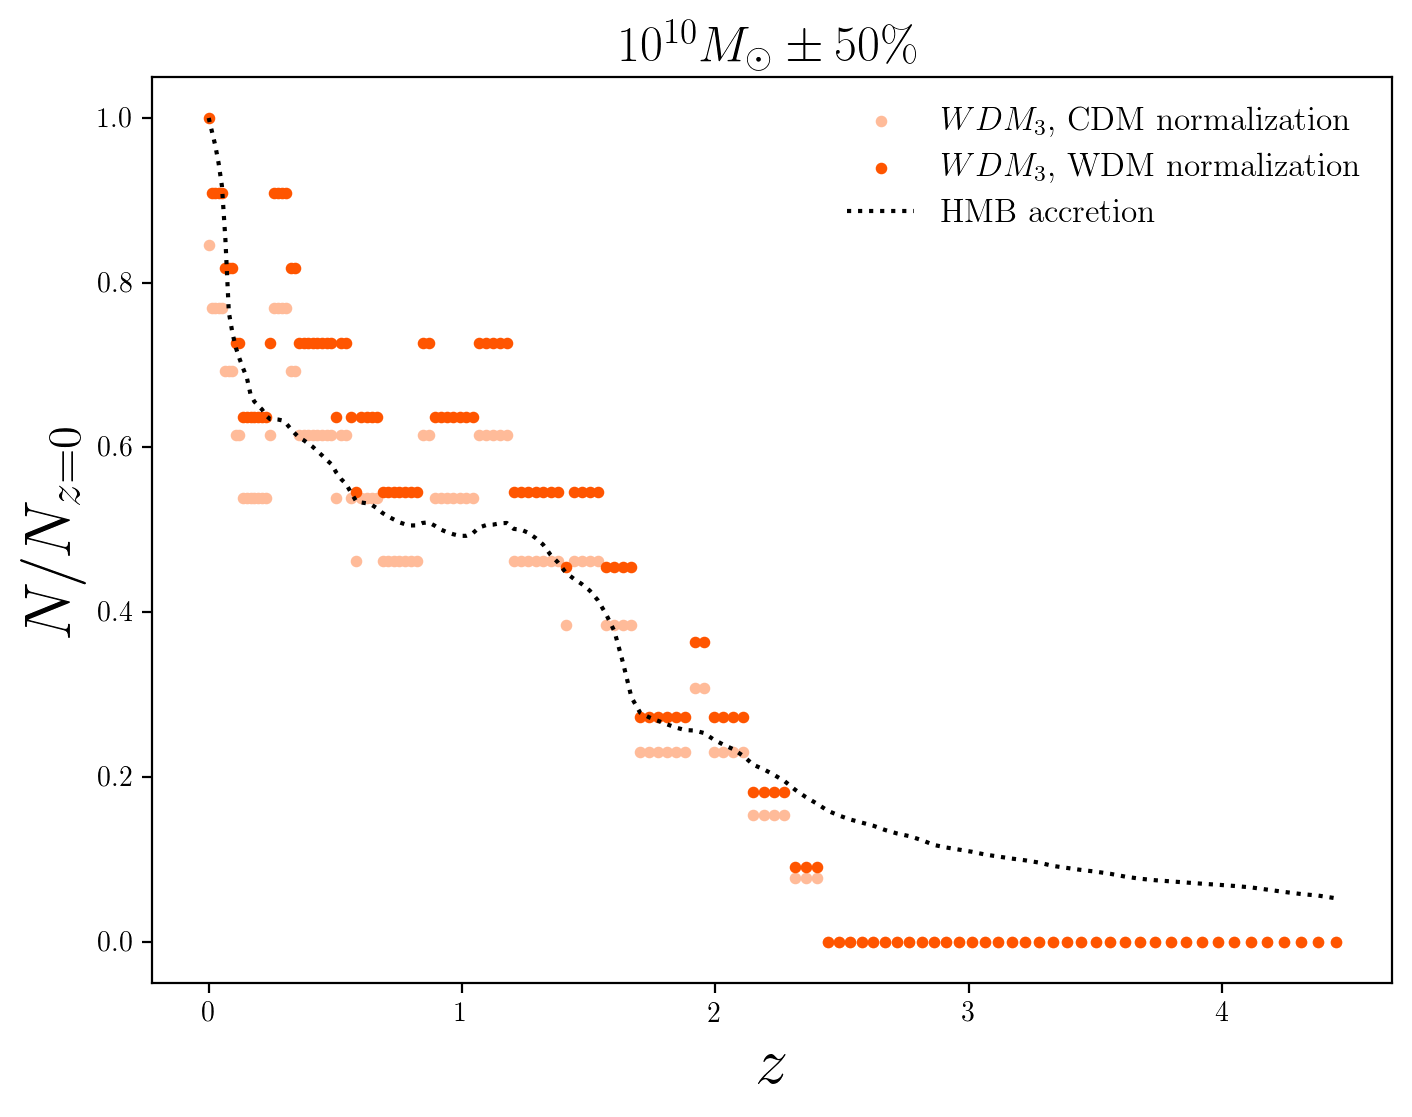

In [62]:
mass = 10

r, z = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=True)
r_rel, z_rel = get_relative_number(wdm, (10**mass), bin_percent = 0.5, cdm_ratio=False)

redshift_cut = 1./wdm.hmb['scale'] - 1. < 4.5

z_hmb = 1./wdm.hmb['scale'] - 1.
mass_hmb = wdm.hmb['mvir']/wdm.hmb['mvir'][0] # virial mass


plt.figure(figsize=(8,6))
plt.scatter(z, r, c=sim_colors['wdm_3'], label=r'$WDM_3$, CDM normalization', s=10)
plt.scatter(z_rel, r_rel, c=sim_colors['wdm_6'], label=r'$WDM_3$, WDM normalization', s=10)
plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='HMB accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{z=0}$', fontsize=24)
plt.title(r'$10^{10} M_\odot \pm 50\%$', fontsize=18)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

### cold dark matter

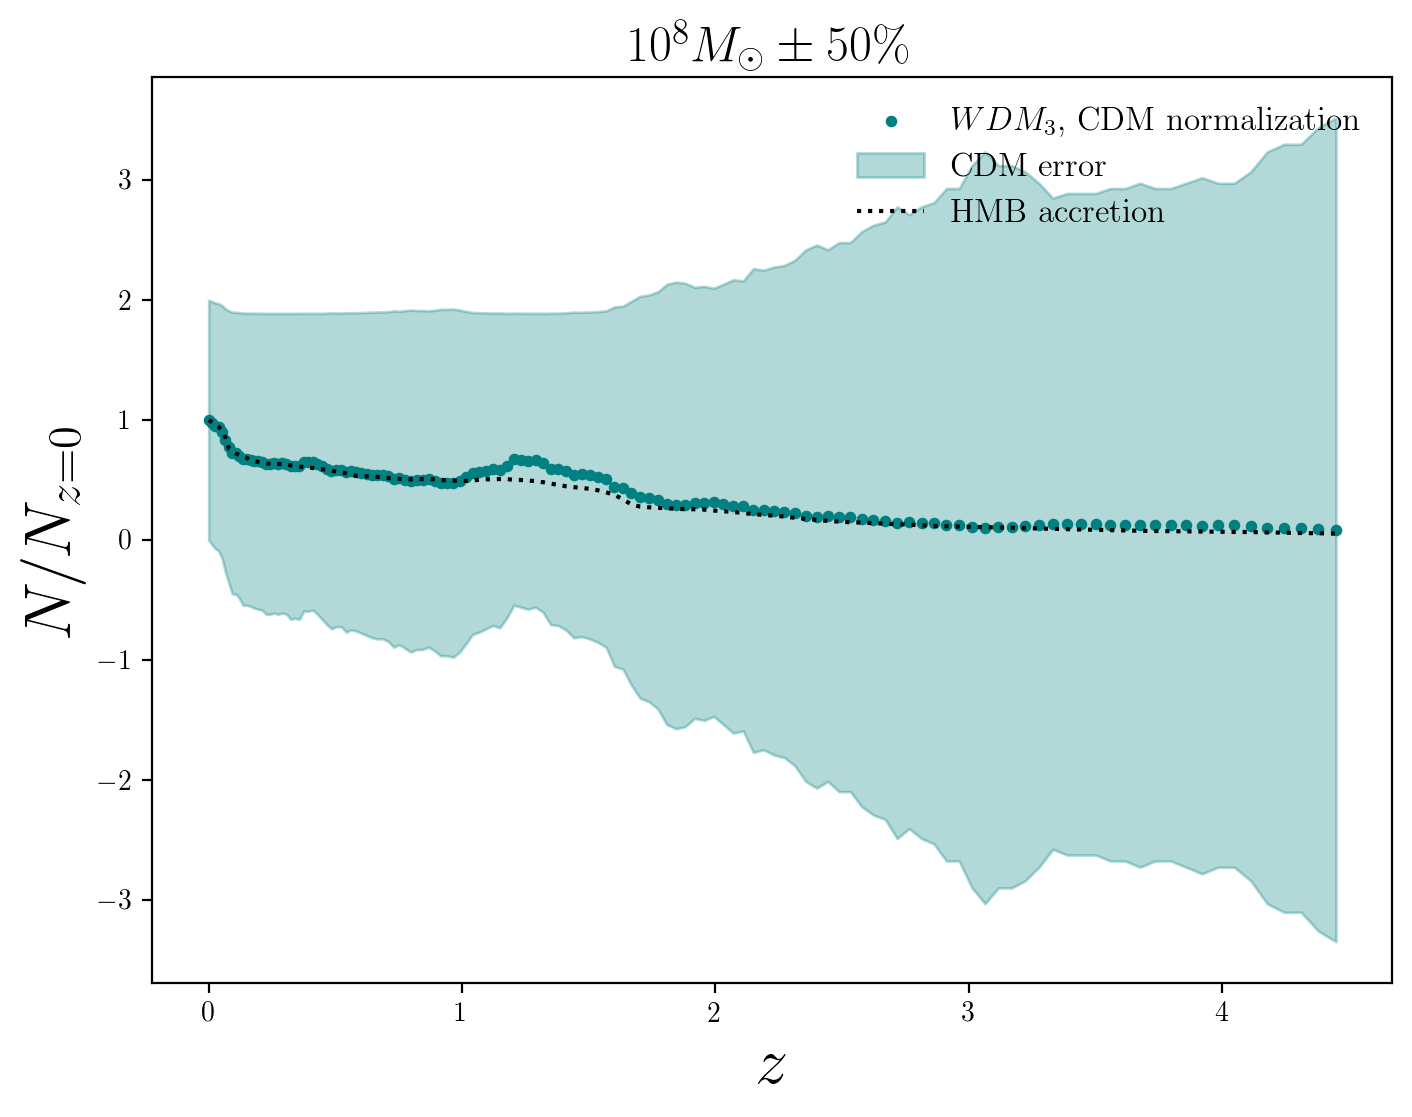

In [74]:
mass = 8

# r, z = get_relative_number(cdm, (10**mass), bin_percent = 0.5)
r_error = 1./np.sqrt(r)

# redshift_cut = 1./wdm.hmb['scale'] - 1. < 4.5

# z_hmb = 1./wdm.hmb['scale'] - 1.
# mass_hmb = wdm.hmb['mvir']/wdm.hmb['mvir'][0] # virial mass


plt.figure(figsize=(8,6))
plt.scatter(z, r, c='teal', label=r'$WDM_3$, CDM normalization', s=10)
plt.fill_between(z, r + r_error, r - r_error, color='teal', alpha = 0.3, label='CDM error')

plt.plot(z_hmb[redshift_cut], mass_hmb[redshift_cut], label='HMB accretion', c='k', linestyle=':')
plt.xlabel(r'$z$', fontsize=24)
plt.ylabel(r'$N/N_{z=0}$', fontsize=24)
plt.title(r'$10^{8} M_\odot \pm 50\%$', fontsize=18)
# plt.yscale('log')
plt.legend(fontsize=12, frameon=False)

In [70]:
1./np.sqrt(np.mean(r)) * r

array([0.12909053, 0.13554506, 0.14845411, 0.14845411, 0.15490864,
       0.17427222, 0.18718127, 0.18718127, 0.18072675, 0.18718127,
       0.1936358 , 0.1936358 , 0.18718127, 0.1936358 , 0.1936358 ,
       0.20009033, 0.20009033, 0.20009033, 0.20654485, 0.18718127,
       0.17427222, 0.16781769, 0.16781769, 0.15490864, 0.16781769,
       0.1936358 , 0.1936358 , 0.21299938, 0.21945391, 0.23236296,
       0.21945391, 0.24527201, 0.25172654, 0.26463559, 0.2904537 ,
       0.2904537 , 0.30981728, 0.29690823, 0.30981728, 0.34208992,
       0.3614535 , 0.36790802, 0.38081708, 0.37436255, 0.43245329,
       0.42599876, 0.45181687, 0.47763498, 0.46472592, 0.47118045,
       0.44536234, 0.43890782, 0.45181687, 0.50345308, 0.52927119,
       0.54218024, 0.59381646, 0.66481625, 0.6777253 , 0.7745432 ,
       0.80036131, 0.81972489, 0.83263394, 0.82617942, 0.87136111,
       0.89717921, 0.90363374, 0.98108806, 1.01336069, 1.00045164,
       1.01336069, 1.02626975, 0.9423609 , 0.88427016, 0.89717

In [71]:
1./np.sqrt(r)

array([3.43511281, 3.35232684, 3.20325921, 3.20325921, 3.13581462,
       2.95647438, 2.85270591, 2.85270591, 2.9032002 , 2.85270591,
       2.80475786, 2.80475786, 2.85270591, 2.80475786, 2.80475786,
       2.759149  , 2.759149  , 2.759149  , 2.71569512, 2.85270591,
       2.95647438, 3.01279324, 3.01279324, 3.13581462, 3.01279324,
       2.80475786, 2.80475786, 2.67423169, 2.63461126, 2.56038192,
       2.63461126, 2.49209276, 2.45993538, 2.39918685, 2.2900752 ,
       2.2900752 , 2.21735578, 2.26504631, 2.21735578, 2.11017302,
       2.05287255, 2.03478522, 2.        , 2.0171677 , 1.87680262,
       1.89096737, 1.83614503, 1.78583011, 1.81046342, 1.79802022,
       1.84940257, 1.86295148, 1.83614503, 1.73943699, 1.69648129,
       1.67616342, 1.6016296 , 1.51369156, 1.49920614, 1.40237893,
       1.3795745 , 1.36318294, 1.35257435, 1.35784756, 1.32217554,
       1.30301256, 1.2983506 , 1.24604638, 1.22604434, 1.23392895,
       1.22604434, 1.21830896, 1.27139229, 1.31248914, 1.30301